In [1]:
import json
import joblib
from pprint import pprint
from pathlib import Path

import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder

import catboost as cb

from isic_helper import DotDict
from isic_helper import get_folds
from isic_helper import compute_auc, compute_pauc

pd.options.display.max_columns = 1000

In [2]:
cfg = DotDict()
cfg.seed = 2022

cfg.models_output_dir = "models"
cfg.model_name = "cb_v1"

In [3]:
id_column = "isic_id"
target_column = "target"
group_column = "patient_id"

In [4]:
def count_features(df, col):
    tmp = df[[id_column, group_column, col]].pivot_table(
        values=id_column, 
        index=group_column, 
        columns=col, 
        aggfunc="count", 
        fill_value=0)
    feature_cols = tmp.columns.tolist()
    tmp.reset_index(inplace=True)
    tmp.index.name = None
    df = df.merge(tmp, on=group_column, how="left")
    return df, feature_cols

def mean_features(df, col, val):
    tmp = df[[id_column, group_column, col, val]].pivot_table(
        values=val, 
        index=group_column, 
        columns=col, 
        aggfunc="mean", 
        fill_value=0)
    tmp.columns = [f"{c}_{val}_mean" for c in tmp.columns.tolist()]
    feature_cols = tmp.columns.tolist()
    tmp.reset_index(inplace=True)
    tmp.index.name = None
    df = df.merge(tmp, on=group_column, how="left")
    return df, feature_cols


def stat_features(df, group_cols, value_col, stats):
    tmp = df.groupby(group_cols)[value_col].agg(stats)
    tmp.columns = [f"{value_col}_{stat}" for stat in stats]
    tmp.reset_index(inplace=True)
    df = df.merge(tmp, on=group_cols, how="left")
    df[f"{value_col}_mean_diff"] = df[value_col] - df[f"{value_col}_mean"]
    return df


def feature_engineering(df):
    new_num_cols = []
    
    df["lesion_size_ratio"] = df["tbp_lv_minorAxisMM"] / df["clin_size_long_diam_mm"]
    new_num_cols += ["lesion_size_ratio"]
    
    df["lesion_distance"] = np.sqrt(df["tbp_lv_x"]**2 + df["tbp_lv_y"]**2 + df["tbp_lv_z"]**2)
    new_num_cols += ["lesion_distance"]
    
    df["hue_contrast"] = df["tbp_lv_H"] - df["tbp_lv_Hext"]
    df, feature_cols = mean_features(df, "anatom_site_general", "hue_contrast")
    new_num_cols += feature_cols
    
    df, feature_cols = count_features(df, "anatom_site_general")
    new_num_cols += feature_cols
    
    df["tbp_lv_A_diff"] =  df["tbp_lv_Aext"] - df["tbp_lv_A"]
    df = stat_features(df, ["patient_id", "tbp_lv_location"], "tbp_lv_A_diff", ["mean"])
    new_num_cols += ["tbp_lv_A_diff_mean_diff"]
    
    df["tbp_lv_B_diff"] =  df["tbp_lv_Bext"] - df["tbp_lv_B"]
    df = stat_features(df, ["patient_id", "tbp_lv_location"], "tbp_lv_B_diff", ["mean"])
    new_num_cols += ["tbp_lv_B_diff_mean_diff"]
    
    df["tbp_lv_L_diff"] =  df["tbp_lv_Lext"] - df["tbp_lv_L"]
    df = stat_features(df, ["patient_id", "tbp_lv_location"], "tbp_lv_L_diff", ["mean"])
    new_num_cols += ["tbp_lv_L_diff_mean_diff"]
    
    df["tbp_lv_L_std_diff"] =  df["tbp_lv_stdLExt"] - df["tbp_lv_stdL"]
    df = stat_features(df, ["patient_id", "tbp_lv_location"], "tbp_lv_L_std_diff", ["mean"])
    new_num_cols += ["tbp_lv_L_std_diff_mean_diff"]
    
    df["color_uniformity"] = df["tbp_lv_color_std_mean"] / df["tbp_lv_radial_color_std_max"]
    df, feature_cols = mean_features(df, "anatom_site_general", "color_uniformity")
    new_num_cols += feature_cols
    
    df["radius"] = np.cos(df["tbp_lv_symm_2axis_angle"]) * np.sqrt(df["tbp_lv_x"]**2 + df["tbp_lv_y"]**2 + df["tbp_lv_z"]**2)
    new_num_cols += ["radius"]
    
    return df, new_num_cols

In [5]:
INPUT_PATH = Path("../input/isic-2024-challenge/")
MODELS_OUTPUT_PATH = Path(f"{cfg.models_output_dir}")
MODELS_OUTPUT_PATH.mkdir(exist_ok=True)

train_metadata = pd.read_csv(INPUT_PATH / "train-metadata.csv", low_memory=False)
test_metadata = pd.read_csv(INPUT_PATH / "test-metadata.csv")

folds_df = get_folds()
train_metadata = train_metadata.merge(folds_df, on=["isic_id", "patient_id"], how="inner")
print(f"Train data size: {train_metadata.shape}")
print(f"Test data size: {test_metadata.shape}")

train_metadata, new_num_cols = feature_engineering(train_metadata.copy())
test_metadata, _ = feature_engineering(test_metadata.copy())

Train data size: (401059, 57)
Test data size: (3, 44)


In [6]:
train_metadata.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,tbp_lv_B,tbp_lv_Bext,tbp_lv_C,tbp_lv_Cext,tbp_lv_H,tbp_lv_Hext,tbp_lv_L,tbp_lv_Lext,tbp_lv_areaMM2,tbp_lv_area_perim_ratio,tbp_lv_color_std_mean,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaL,tbp_lv_deltaLB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_location,tbp_lv_location_simple,tbp_lv_minorAxisMM,tbp_lv_nevi_confidence,tbp_lv_norm_border,tbp_lv_norm_color,tbp_lv_perimeterMM,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence,multiclass_target,fold,lesion_size_ratio,lesion_distance,hue_contrast,anterior torso_hue_contrast_mean,head/neck_hue_contrast_mean,lower extremity_hue_contrast_mean,posterior torso_hue_contrast_mean,upper extremity_hue_contrast_mean,anterior torso,head/neck,lower extremity,posterior torso,upper extremity,tbp_lv_A_diff,tbp_lv_A_diff_mean,tbp_lv_A_diff_mean_diff,tbp_lv_B_diff,tbp_lv_B_diff_mean,tbp_lv_B_diff_mean_diff,tbp_lv_L_diff,tbp_lv_L_diff_mean,tbp_lv_L_diff_mean_diff,tbp_lv_L_std_diff,tbp_lv_L_std_diff_mean,tbp_lv_L_std_diff_mean_diff,color_uniformity,anterior torso_color_uniformity_mean,head/neck_color_uniformity_mean,lower extremity_color_uniformity_mean,posterior torso_color_uniformity_mean,upper extremity_color_uniformity_mean,radius
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,16.261975,26.922447,23.954773,33.684638,28.953117,53.058545,55.828924,54.367448,62.025701,3.152561,27.476170,0.00000,3.982447,2.967674,-7.658253,8.360566,5.784302,0.901302,Right Leg - Upper,Right Leg,1.543016,2.628592e-03,7.091360,0.000000,9.307003,0.00000,2.036195,2.637780,0.590476,85,-182.703552,613.493652,-42.427948,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282,0_Benign:Weak,4,0.507571,641.525666,-2.770379,-4.689356,-1.110874,-4.336041,-4.336349,-4.783558,191.0,8.0,118.0,121.0,72.0,-3.982447,-3.685802,-0.296645,-2.967674,-1.073571,-1.894103,7.658253,9.775050,-2.116797,0.601585,-0.521064,1.122649,NaN,inf,1.154445,1.015490,inf,inf,-631.502882
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,25.364740,26.331000,24.549290,41.219030,35.299260,39.702910,44.064040,48.861520,55.362360,0.919497,12.235290,0.00000,6.347830,1.781713,-6.500838,6.839008,4.987244,0.639885,Head & Neck,Head & Neck,0.821918,1.334303e-07,2.116402,0.000000,3.354148,0.00000,0.853227,3.912844,0.285714,55,-0.078308,1575.687000,57.174500,Memorial Sloan Kettering Cancer Center,CC-BY,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455,0_Benign:Strong,1,0.747198,1576.723962,-4.361130,-4.421667,-3.534137,-6.157595,-3.668893,-4.114276,27.0,8.0,37.0,16.0,25.0,-6.347830,-3.938782,-2.409048,-1.781710,-1.165544,-0.616166,6.500840,7.545856,-1.045016,3.059617,1.603739,1.455878,NaN,1.069864,1.001586,inf,inf,inf,34.887787
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,17.128170,37.970460,33.485410,44.174920,37.611800,59.265850,62.909730,53.961180,61.670520,3.265153,24.184620,0.00000,5.447655,4.485044,-7.709336,9.092376,6.290359,0.932147,Torso Back Top Third,Torso Back,1.194905,2.959177e-04,4.798335,0.000000,8.886309,0.00000,1.743651,1.950777,0.361905,105,123.649700,1472.010000,232.908900,Memorial Sloan Kettering Cancer Center,CC-BY,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040,0_Benign:Weak,5,0.351443,1495.442825,-3.643880,-4.190243,-0.958026,-5.811371,-3.632645,-3.084955,527.0,34.0,536.0,466.0,296.0,-5.447660,-4.309035,-1.138625,-4.485050,-3.577588,-0.907462,7.709340,6.455907,1.253433,0.207126,0.544733,-0.337607,NaN,inf,inf,inf,inf,inf,-360.340481
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: 

In [7]:
ord_categorical_features = [
#     "sex", 
#     "anatom_site_general", 
    "tbp_tile_type", 
    "tbp_lv_location", 
#     "tbp_lv_location_simple",
    "attribution", "copyright_license"
]
ohe_categorical_features = []
numerical_features = [
    "age_approx", 
    "clin_size_long_diam_mm",
    "tbp_lv_A", "tbp_lv_Aext",
    "tbp_lv_B", "tbp_lv_Bext",
    "tbp_lv_C", "tbp_lv_Cext",
    "tbp_lv_H", "tbp_lv_Hext",
    "tbp_lv_L", "tbp_lv_Lext",
    "tbp_lv_areaMM2",
    "tbp_lv_area_perim_ratio",
    "tbp_lv_color_std_mean",
    "tbp_lv_deltaA", "tbp_lv_deltaB", "tbp_lv_deltaL", "tbp_lv_deltaLB", "tbp_lv_deltaLBnorm",
    "tbp_lv_eccentricity",
    "tbp_lv_minorAxisMM",
    "tbp_lv_nevi_confidence",
    "tbp_lv_norm_border", "tbp_lv_norm_color",
    "tbp_lv_perimeterMM",
    "tbp_lv_radial_color_std_max",
    "tbp_lv_stdL", "tbp_lv_stdLExt",
    "tbp_lv_symm_2axis", "tbp_lv_symm_2axis_angle",
    "tbp_lv_x", "tbp_lv_y", "tbp_lv_z"
]
numerical_features += new_num_cols

mixed_encoded_preprocessor = ColumnTransformer(
    [
        ("numerical", "passthrough", numerical_features),
        (
            "ord_categorical",
            OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-2, encoded_missing_value=-1, dtype=int),
            ord_categorical_features,
        ),
        (
            "ohe_categorical",
            OneHotEncoder(sparse_output=False),
            ohe_categorical_features
        )
    ],
    verbose_feature_names_out=False,

)
mixed_encoded_preprocessor.set_output(transform="pandas")

with open(f"{cfg.model_name}_encoder.joblib", "wb") as f:
    joblib.dump(mixed_encoded_preprocessor, f)

In [8]:
train_ids = train_metadata[id_column]
groups = train_metadata[group_column]
folds = train_metadata["fold"]

enc = mixed_encoded_preprocessor.fit(train_metadata)
X_train = enc.transform(train_metadata)
y_train = train_metadata[target_column]

categorical_features = ord_categorical_features[:]
for ohe_col in ohe_categorical_features:
    categorical_features += [col for col in X_train.columns if col.startswith(ohe_col)]

print(f"Total number of columns: {len(X_train.columns)}")

Total number of columns: 60


In [9]:
class PAUC:
    def get_final_error(self, error, weight):
        return error

    def is_max_optimal(self):
        return True

    def evaluate(self, approxes, target, weight):
        y_true = target.astype(int)
        y_pred = approxes[0].astype(float)
        
        score = compute_pauc(y_true, y_pred, min_tpr=0.8)
        
        return score, 1.0

params = {
    "objective": "Logloss",
    "learning_rate": 0.05,
    "max_depth": 8,
    "l2_leaf_reg": 5,
    "random_state": cfg.seed,
}
num_rounds = 3000
es_rounds = 250
log_rounds = 50

In [10]:
best_num_rounds = {}
val_auc_scores = {}
val_pauc_scores = {}
all_folds = np.sort(folds.unique())
oof_predictions = np.zeros(X_train.shape[0])
feature_importances = 0
for fold in all_folds:
    print(f"Running fold: {fold}")
    dev_index = folds[folds != fold].index
    val_index = folds[folds == fold].index
    
    X_dev = X_train.loc[dev_index, :]
    y_dev = y_train[dev_index]
    
    X_val = X_train.loc[val_index, :]
    y_val = y_train[val_index]
    
    cb_dataset_dev = cb.Pool(X_dev, y_dev, cat_features=categorical_features)
    cb_dataset_val = cb.Pool(X_val, y_val, cat_features=categorical_features)
    
    model = cb.CatBoostClassifier(**params, iterations=num_rounds, eval_metric="AUC")
    
    model.fit(cb_dataset_dev, eval_set=cb_dataset_val, 
              early_stopping_rounds=es_rounds, 
              metric_period=log_rounds, use_best_model=True,
              init_model=None)
    model.save_model(MODELS_OUTPUT_PATH / f"{cfg.model_name}_fold_{fold}.txt")
    if fold == 1:
        feature_names = model.feature_names_
    feature_importances += model.feature_importances_
    best_num_rounds[f"fold_{fold}"] = model.best_iteration_
    
    val_preds = model.predict_proba(X_val)[:, -1]
    oof_predictions[val_index] = val_preds
    
    val_pauc_scores[f"fold_{fold}"] = compute_pauc(y_val, val_preds, min_tpr=0.8)
    val_auc_scores[f"fold_{fold}"] = compute_auc(y_val, val_preds)
    print("\n")

feature_importances /= len(all_folds)

print("Val AUC scores:")
pprint(val_auc_scores)
print("Val PAUC scores:")
pprint(val_pauc_scores)

oof_preds_df = pd.DataFrame({
    id_column: train_ids,
    group_column: groups,
    "fold": folds,
    target_column: y_train,
    f"oof_{cfg.model_name}": oof_predictions
})
oof_preds_df.to_csv(f"oof_preds_{cfg.model_name}.csv", index=False)

cv_auc_oof = compute_auc(oof_preds_df[target_column], oof_preds_df[f"oof_{cfg.model_name}"])
cv_pauc_oof = compute_pauc(oof_preds_df[target_column], oof_preds_df[f"oof_{cfg.model_name}"], min_tpr=0.8)

cv_auc_avg = np.mean(list(val_auc_scores.values()))
cv_pauc_avg = np.mean(list(val_pauc_scores.values()))

cv_auc_std = np.std(list(val_auc_scores.values()))
cv_pauc_std = np.std(list(val_pauc_scores.values()))

print(f"CV AUC OOF: {cv_auc_oof}")
print(f"CV PAUC OOF: {cv_pauc_oof}")
print(f"CV AUC AVG: {cv_auc_avg}")
print(f"CV PAUC AVG: {cv_pauc_avg}")
print(f"CV AUC STD: {cv_auc_std}")
print(f"CV PAUC STD: {cv_pauc_std}")
print(X_train.columns)

Running fold: 1


0:	test: 0.6816698	best: 0.6816698 (0)	total: 516ms	remaining: 25m 46s
50:	test: 0.9336852	best: 0.9339642 (49)	total: 20.5s	remaining: 19m 43s
100:	test: 0.9441832	best: 0.9441832 (100)	total: 39.9s	remaining: 19m 4s
150:	test: 0.9476617	best: 0.9476617 (150)	total: 59s	remaining: 18m 33s
200:	test: 0.9489224	best: 0.9489710 (198)	total: 1m 17s	remaining: 18m 5s
250:	test: 0.9503979	best: 0.9503979 (250)	total: 1m 36s	remaining: 17m 35s
300:	test: 0.9515889	best: 0.9516518 (299)	total: 1m 55s	remaining: 17m 16s
350:	test: 0.9515589	best: 0.9523882 (334)	total: 2m 14s	remaining: 16m 58s
400:	test: 0.9505631	best: 0.9523882 (334)	total: 2m 33s	remaining: 16m 34s
450:	test: 0.9503286	best: 0.9523882 (334)	total: 2m 51s	remaining: 16m 11s
500:	test: 0.9504893	best: 0.9523882 (334)	total: 3m 9s	remaining: 15m 44s
550:	test: 0.9508493	best: 0.9523882 (334)	total: 3m 27s	remaining: 15m 23s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 0.9523881911
bestIteration = 334

Sh

0:	test: 0.6502911	best: 0.6502911 (0)	total: 404ms	remaining: 20m 11s
50:	test: 0.9149425	best: 0.9149425 (50)	total: 20.4s	remaining: 19m 40s
100:	test: 0.9313578	best: 0.9313578 (100)	total: 38.7s	remaining: 18m 31s
150:	test: 0.9364313	best: 0.9364422 (147)	total: 56.3s	remaining: 17m 42s
200:	test: 0.9374940	best: 0.9381221 (194)	total: 1m 13s	remaining: 17m 9s
250:	test: 0.9414169	best: 0.9414169 (250)	total: 1m 31s	remaining: 16m 47s
300:	test: 0.9442540	best: 0.9444363 (290)	total: 1m 50s	remaining: 16m 35s
350:	test: 0.9449070	best: 0.9449259 (347)	total: 2m 9s	remaining: 16m 15s
400:	test: 0.9457927	best: 0.9458154 (398)	total: 2m 27s	remaining: 15m 57s
450:	test: 0.9466042	best: 0.9468658 (418)	total: 2m 46s	remaining: 15m 43s
500:	test: 0.9477292	best: 0.9477478 (498)	total: 3m 6s	remaining: 15m 28s
550:	test: 0.9473508	best: 0.9478943 (543)	total: 3m 24s	remaining: 15m 9s
600:	test: 0.9468086	best: 0.9478943 (543)	total: 3m 43s	remaining: 14m 50s
650:	test: 0.9469021	best:

0:	test: 0.8279961	best: 0.8279961 (0)	total: 559ms	remaining: 27m 57s
50:	test: 0.9260556	best: 0.9260556 (50)	total: 20.4s	remaining: 19m 38s
100:	test: 0.9341469	best: 0.9343057 (99)	total: 39.6s	remaining: 18m 56s
150:	test: 0.9393258	best: 0.9393258 (150)	total: 59s	remaining: 18m 33s
200:	test: 0.9433128	best: 0.9434721 (195)	total: 1m 18s	remaining: 18m 13s
250:	test: 0.9448558	best: 0.9448558 (250)	total: 1m 37s	remaining: 17m 50s
300:	test: 0.9454047	best: 0.9457296 (295)	total: 1m 55s	remaining: 17m 16s
350:	test: 0.9447587	best: 0.9457296 (295)	total: 2m 14s	remaining: 16m 57s
400:	test: 0.9450292	best: 0.9457296 (295)	total: 2m 33s	remaining: 16m 35s
450:	test: 0.9440472	best: 0.9457296 (295)	total: 2m 52s	remaining: 16m 17s
500:	test: 0.9440026	best: 0.9457296 (295)	total: 3m 11s	remaining: 15m 55s
Stopped by overfitting detector  (250 iterations wait)

bestTest = 0.9457296489
bestIteration = 295

Shrink model to first 296 iterations.


Running fold: 4


0:	test: 0.7642893	best: 0.7642893 (0)	total: 450ms	remaining: 22m 31s
50:	test: 0.9395348	best: 0.9395348 (50)	total: 20.1s	remaining: 19m 24s
100:	test: 0.9539986	best: 0.9539986 (100)	total: 39.5s	remaining: 18m 53s
150:	test: 0.9591251	best: 0.9591251 (150)	total: 59.3s	remaining: 18m 38s
200:	test: 0.9609825	best: 0.9612436 (193)	total: 1m 18s	remaining: 18m 10s
250:	test: 0.9629555	best: 0.9629555 (250)	total: 1m 37s	remaining: 17m 50s
300:	test: 0.9629853	best: 0.9629853 (300)	total: 1m 57s	remaining: 17m 29s
350:	test: 0.9641571	best: 0.9642978 (343)	total: 2m 15s	remaining: 17m 3s
400:	test: 0.9660762	best: 0.9660762 (400)	total: 2m 35s	remaining: 16m 44s
450:	test: 0.9682050	best: 0.9682481 (448)	total: 2m 53s	remaining: 16m 23s
500:	test: 0.9702033	best: 0.9702033 (500)	total: 3m 13s	remaining: 16m 4s
550:	test: 0.9707008	best: 0.9707008 (550)	total: 3m 31s	remaining: 15m 41s
600:	test: 0.9713209	best: 0.9713209 (600)	total: 3m 49s	remaining: 15m 17s
650:	test: 0.9717572	bes

0:	test: 0.8167052	best: 0.8167052 (0)	total: 617ms	remaining: 30m 50s
50:	test: 0.9231644	best: 0.9231644 (50)	total: 19.6s	remaining: 18m 56s
100:	test: 0.9351716	best: 0.9351716 (100)	total: 39.4s	remaining: 18m 51s
150:	test: 0.9409355	best: 0.9409355 (150)	total: 58.6s	remaining: 18m 25s
200:	test: 0.9439147	best: 0.9441345 (197)	total: 1m 17s	remaining: 18m 2s
250:	test: 0.9440149	best: 0.9444072 (209)	total: 1m 35s	remaining: 17m 31s
300:	test: 0.9453817	best: 0.9455989 (297)	total: 1m 54s	remaining: 17m 9s
350:	test: 0.9462997	best: 0.9467742 (341)	total: 2m 13s	remaining: 16m 51s
400:	test: 0.9465568	best: 0.9470801 (385)	total: 2m 32s	remaining: 16m 30s
450:	test: 0.9461365	best: 0.9470801 (385)	total: 2m 51s	remaining: 16m 11s
500:	test: 0.9455613	best: 0.9470801 (385)	total: 3m 10s	remaining: 15m 49s
550:	test: 0.9445492	best: 0.9470801 (385)	total: 3m 29s	remaining: 15m 30s
600:	test: 0.9442521	best: 0.9470801 (385)	total: 3m 48s	remaining: 15m 12s
Stopped by overfitting d

<Axes: >

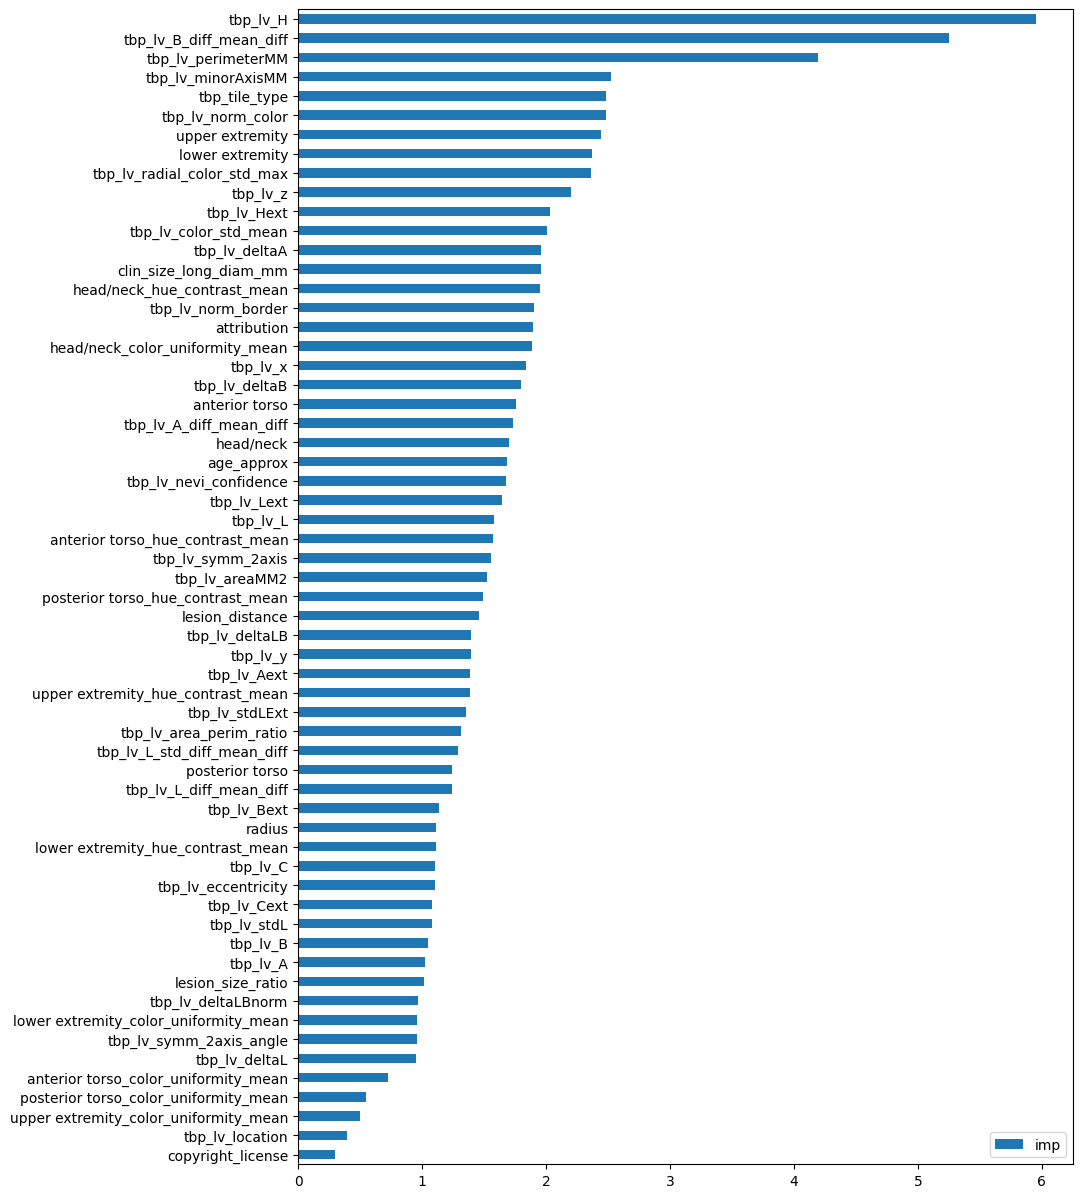

In [11]:
imp = pd.DataFrame.from_dict(dict(zip(feature_names, feature_importances)), 
                             orient="index", columns=["imp"]).sort_values("imp", ascending=True)
imp.plot(kind="barh", figsize=(10, 15))

In [12]:
metadata = {
    "params": params,
    "num_rounds": num_rounds,
    "es_rounds": es_rounds,
    "best_num_rounds": best_num_rounds,
    "val_auc_scores": val_auc_scores,
    "val_pauc_scores": val_pauc_scores,
    "cv_auc_oof": cv_auc_oof,
    "cv_pauc_oof": cv_pauc_oof,
    "cv_auc_avg": cv_auc_avg,
    "cv_pauc_avg": cv_pauc_avg
}

with open(f"{cfg.model_name}_run_metadata.json", "w") as f:
    json.dump(metadata, f)